In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import models
from sklearn.metrics import roc_auc_score, classification_report
from torch.utils.data import DataLoader, Dataset, random_split

In [19]:
class LensDataset(Dataset):
    def __init__(self, lens_dir, nonlens_dir, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []

        # Load Lensed Images (Label = 1)
        for file in os.listdir(lens_dir):
            img = np.load(os.path.join(lens_dir, file))
            self.data.append(img)
            self.labels.append(1)

        # Load Non-Lensed Images (Label = 0)
        for file in os.listdir(nonlens_dir):
            img = np.load(os.path.join(nonlens_dir, file))
            self.data.append(img)
            self.labels.append(0)

        # Convert to NumPy array
        self.data = np.array(self.data)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]

        # Convert to tensor
        img = torch.tensor(img, dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, label


In [4]:
# Define dataset paths
data_root = "C:\\Users\\DTSC302\\Desktop\\Anannya\\gsoc\\lens-finding-test"
train_lens_dir = os.path.join(data_root, "train_lenses")
train_nonlens_dir = os.path.join(data_root, "train_nonlenses")
test_lens_dir = os.path.join(data_root, "test_lenses")
test_nonlens_dir = os.path.join(data_root, "test_nonlenses")

# Load datasets
dataset = LensDataset(train_lens_dir, train_nonlens_dir)
test_dataset = LensDataset(test_lens_dir, test_nonlens_dir)

# Split into Train (90%) and Validation (10%)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 27364, Validation samples: 3041, Test samples: 19650


In [21]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.Lambda(lambda x: x.astype(np.uint8)),  # Ensure NumPy format
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization
])
dataset = LensDataset(train_lens_dir, train_nonlens_dir, transform=transform)



In [6]:
# Define class weights for imbalanced data
class_counts = np.bincount(dataset.labels)
batch_size = 64

from torch.utils.data import SubsetRandomSampler

# Get indices of both classes
lens_indices = [i for i, label in enumerate(dataset.labels) if label == 1]
nonlens_indices = [i for i, label in enumerate(dataset.labels) if label == 0]

# Oversample the minority class
oversampled_lens_indices = np.random.choice(lens_indices, size=len(nonlens_indices), replace=True)
balanced_indices = np.concatenate([oversampled_lens_indices, nonlens_indices])

# Create a new sampler
balanced_sampler = SubsetRandomSampler(balanced_indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=balanced_sampler)


In [7]:


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
# Preliminary EDA
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of test samples:", len(test_dataset))

Number of training samples: 27364
Number of validation samples: 3041
Number of test samples: 19650


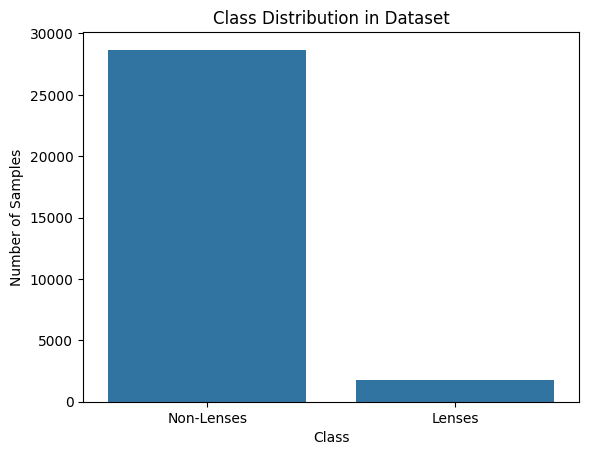

In [17]:
# Visualizing class distribution
sns.barplot(x=['Non-Lenses', 'Lenses'], y=class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Dataset")
plt.show()

In [11]:
# Define ResNet-18 Model
class ResNet18Classifier(nn.Module):
    def __init__(self):
        super(ResNet18Classifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)
    
    def forward(self, x):
        return self.model(x)

In [12]:
# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18Classifier().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

class_counts = np.bincount(dataset.labels)
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)


c:\Users\DTSC302\Desktop\Anannya\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DTSC302\Desktop\Anannya\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 0.3291
Epoch 2/10, Loss: 0.2191
Epoch 3/10, Loss: 0.2005
Epoch 4/10, Loss: 0.1803
Epoch 5/10, Loss: 0.3053
Epoch 6/10, Loss: 0.2755
Epoch 7/10, Loss: 0.2043
Epoch 8/10, Loss: 0.1854
Epoch 9/10, Loss: 0.1478
Epoch 10/10, Loss: 0.1363


In [14]:
# Validation
model.eval()
val_labels = []
val_preds = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)[:, 1]
        val_preds.extend(probs.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

roc_auc = roc_auc_score(val_labels, val_preds)
print(f"Validation ROC-AUC: {roc_auc:.4f}")

Validation ROC-AUC: 0.9792


In [15]:
# Test Classification Report
test_labels = []
test_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(test_labels, test_preds))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     19455
           1       0.09      0.92      0.16       195

    accuracy                           0.90     19650
   macro avg       0.54      0.91      0.56     19650
weighted avg       0.99      0.90      0.94     19650



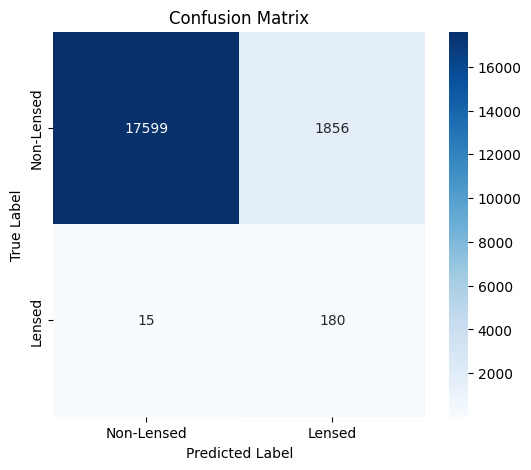

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Lensed", "Lensed"], yticklabels=["Non-Lensed", "Lensed"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Save model weights
torch.save(model.state_dict(), "attempt3.pth")